In [3]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import random
import matplotlib.pyplot as plt
from psychopy import visual, event, core
import cv2 

In [4]:
def ShowImage(image):
    plt.imshow(image, cmap='gray', vmin=0, vmax=1)
    plt.axis('off') 
    plt.show()


def PiImage(ori = None):
    size, fixed_length, diff, leg_width, bar_height = 128, 80, 20, 1, 2
    Pi = np.zeros((size, size)) 

    spacing = size // 3
    left_x = spacing
    right_x = size - spacing 

    bar_y = int(size * 1/4) 

    if ori == 'right':
        left_len = fixed_length
        right_len = fixed_length + diff
    elif ori == 'left':
        right_len = fixed_length
        left_len = fixed_length + diff

    Pi[bar_y:bar_y + left_len // 2, left_x:left_x + leg_width] = 1
    Pi[bar_y:bar_y + right_len // 2, right_x:right_x + leg_width] = 1

    bar_y1 = bar_y - bar_height // 2
    bar_y2 = bar_y + bar_height // 2
    Pi[bar_y1:bar_y2, left_x + leg_width:right_x] = 1
            
    return Pi.astype(np.float32)

def PiMask(size=128, num_shapes=10):
    mask = np.zeros((size, size), dtype=np.uint8)
    spacing = size // 3
    left_x = spacing
    right_x = size - spacing 
    for _ in range(num_shapes):
        for x_base in [left_x, right_x]:
            x = x_base + np.random.randint(-5, 5)
            y1 = np.random.randint(20, size - 20)
            y2 = y1 + np.random.randint(5, 20)
            cv2.line(mask, (x, y1), (x, y2), 255, thickness=1)

        x1 = np.random.randint(left_x, right_x)
        y = np.random.randint(size // 6, size // 4)
        angle = np.random.choice([-1, 1]) * np.random.randint(5, 15)
        x2 = x1 + angle
        y2 = y + np.random.randint(5, 15)
        cv2.line(mask, (x1, y), (x2, y2), 255, thickness=1)
        
    return (mask / 255).astype(np.float32)

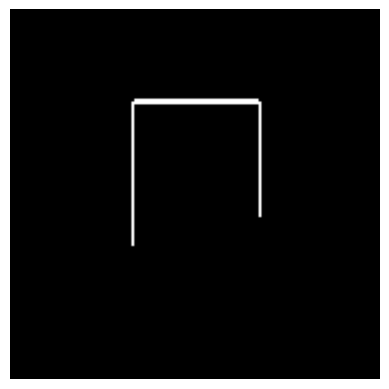

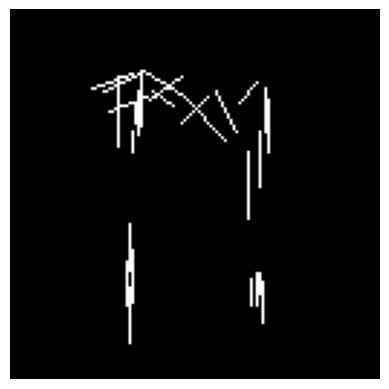

In [5]:
ShowImage(PiImage(ori = 'left'))
ShowImage(PiMask())

Experiment aborted by user.
Experiment aborted by user.
2.0998 	WARNING 	Monitor specification not found. Creating a temporary one...


ValueError: x and y must have same first dimension, but have shapes (50,) and (0,)

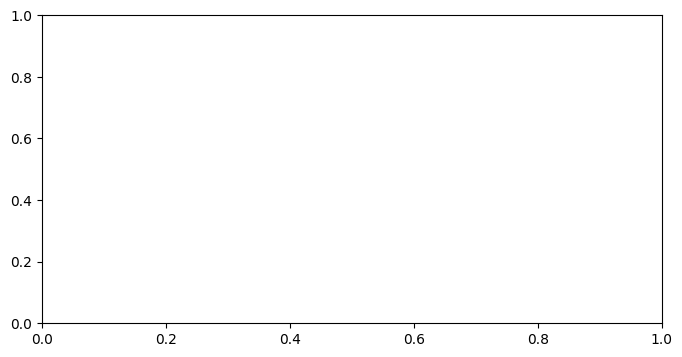

In [9]:
def Norm(image):
    return 2 * image - 1

# Visual Setup
win = visual.Window(size=(1920, 1080), color=-1, units="pix", fullscr=False)
stim = visual.ImageStim(win, size=(512, 512), units="pix")

# Parameters
oris = ['left', 'right']
soa = 0.1
soa_practice = [0.1, 0.15, 0.2]
step_size = 0.005
n_trials = 50
n_practices = 10
noise_gap = 0.3
correct_counter = 0
data = []

# Welcome Screen
text = visual.TextStim(win, text="Welcome to the experiment! Press SPACE to begin the instruction", color=1.0, height=24)
text.draw()
win.flip()
event.waitKeys(keyList=['space'])

# Instruction Screen
text = visual.TextStim(win, text="In this experiment, you will see a Pi-shape target. The two legs of the Pi-shape stimulus has different length.\
                                        The below one has a longer left leg.\
                                        \n\n The Pi-shaped target will be briefly flashed and then immediately masked by some random lines, your task is to identify which leg is longer after the Pi-shape target is briefly presented at the center of the screen\
                                        \n\n If you think the left leg is longer, press 'x'. If you think the right leg is longer, press 'm'.\
                                        \n\n Press SPACE to continue", color=1.0, height=24, pos = (0, 300))
text.draw()
image = visual.ImageStim(image = np.flipud(Norm(PiImage(ori = 'left'))), win = win, size=(512, 512), pos = (0, -200), units="pix")
image.draw()
win.flip()
event.waitKeys(keyList=['space'])

# Practice trail screen
text = visual.TextStim(win, text="We will begin with several practice trials, feedback on correctness will be provided after each trial.\
                                \n\n If you think the left leg is longer, press 'x'. If you think the right leg is longer, press 'm'.\
                                \n\n Press SPACE to start the practice trials. ", color=1.0, height=24)
text.draw()
win.flip()
event.waitKeys(keyList=['space'])
for trial in range(n_practices):
    if 'escape' in event.getKeys():
        print("Experiment aborted during practice.")
        break

    # Fixation
    fixation = visual.TextStim(win, text="+", color=1.0, height=48)
    fixation.draw()
    win.flip()
    core.wait(0.5)

    # Stimulus
    ori, practice_soa = random.choice(oris), random.choice(soa_practice)
    stim.image = np.flipud(Norm(PiImage(ori = ori)))
    stim.draw()
    win.flip()
    core.wait(soa)
    stim.image = np.flipud(Norm(PiMask()))
    stim.draw()
    win.flip()
    core.wait(noise_gap)
    win.flip()

    wait = visual.TextStim(win, text="Choose the orientation", color=1.0, height=48)
    wait.draw()
    win.flip()
    keys = event.waitKeys(keyList=['x', 'm', 'escape'])
    if 'escape' in keys:
        print("Experiment aborted by user.")
        break
    win.flip()

    response = 'left' if keys[0] == 'x' else 'right'
    correct = response == ori

    # Feedback 
    feedback_text = "Right" if correct else "Wrong"
    feedback_color = 'green' if correct else 'red'
    
    feedback = visual.TextStim(win, text=feedback_text, color=feedback_color, height=36)
    feedback.draw()
    win.flip()
    core.wait(0.5)
    win.flip()
    core.wait(0.5)

# Wait for spacebar to begin
event.waitKeys(keyList=['space'])
win.flip()


# --- Main Staircase Block ---
text = visual.TextStim(win, text="Excellent! Here comes the main experiment. This time the task is more difficult, please pay attention\
                                \n\n If you think the left leg is longer, press 'x'. If you think the right leg is longer, press 'm'.\
                                \n\n Press SPACE to start the main experiment. ", color=1.0, height=24)

text.draw()
win.flip()
event.waitKeys(keyList=['space'])

for trial in range(n_trials):
    if 'escape' in event.getKeys():
        print("Experiment aborted by user.")
        break

    fixation = visual.TextStim(win, text="+", color=1.0, height=48)
    fixation.draw()
    win.flip()
    core.wait(0.5)
    ori = random.choice(oris)
    stim.image = np.flipud(Norm(PiImage(ori = ori)))
    stim.draw()
    win.flip()
    core.wait(soa)
    stim.image = np.flipud(Norm(PiMask()))
    stim.draw()
    win.flip()
    core.wait(noise_gap)
    win.flip()
    
    keys = event.waitKeys(keyList=['x','m'] + ['escape'])
    if 'escape' in keys:
        print("Experiment aborted by user.")
        break

    response = 'left' if keys[0] == 'x' else 'right'
    correct = response == ori
    data.append({"trial": trial+1, "orientation": ori, "response": response,
                 "correct": correct, "soa": soa})
    if correct:
        correct_counter += 1
        if correct_counter == 2:
            soa = max(0, soa - step_size)
            correct_counter = 0
    else:
        soa = min(1.0, soa + step_size)
        correct_counter = 0
    core.wait(0.5)

# Cleanup 
win.close()

# ---------- Plot ----------
soas = [d["soa"] for d in data]
plt.figure(figsize=(8, 4))
plt.plot(range(1, n_trials + 1), soas, marker='o')
plt.xlabel("Trial")
plt.ylabel("Alpha (Visibility)")
plt.title("2-Down-1-Up Staircase")
plt.grid(True)
plt.show()

# Optional: save data
import pandas as pd
df = pd.DataFrame(data)
df.to_csv("Results.csv", index=False)